<a href="https://www.kaggle.com/code/amartinez111/house-price-predictor?scriptVersionId=114427061" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# !pip install -U tensorboard witwidget keract
!pip install ipython

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory-
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import time
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (logs/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-price-tehran-iran/housePrice.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [3]:
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.layers import Dense, Flatten, Input
# from keract import get_activations, display_activations
import scipy as sp

from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.ticker as ticker
import matplotlib.patches as patches

from IPython.display import HTML


from math import sin, cos, pi
import math
import re # regex expresions

#  first of all, i create animation figure to see training stats

In [4]:
class AnimationFigure():
    def __init__(self, frames, shape, show_weights):
        self.fig = plt.figure(figsize=(14, 11), constrained_layout=True)
        # grid = fig.add_gridspec(2, 2, hspace=0.25,wspace=0.25)
        self.grid = self.fig.add_gridspec(1, 2)
        # grid.update(left=0.6,right=0.5,top=0.965,bottom=0.03)
        self.frames = frames
        
        self.gridGeneralFunction = self.grid[0].subgridspec(2, 1)
        self.axPredict = self.fig.add_subplot(self.gridGeneralFunction[0])
        self.axJFunction = self.fig.add_subplot(self.gridGeneralFunction[1])
        
        self.gridParametersChange = self.grid[1].subgridspec(shape[0] * shape[1] + 1, 1) 
        
        self.wShape = shape
        
        self.wAxis = np.zeros(shape, dtype=object)
        self.bAxis = np.zeros((1), dtype=object)
        
        self.bAxis.itemset((0), self.fig.add_subplot(self.gridParametersChange[shape[0] * shape[1]]))
        
        if show_weights:
            for f in range(0, shape[0]):
                for c in range(0, shape[1]):
                    self.wAxis.itemset((f, c), self.fig.add_subplot(self.gridParametersChange[shape[1] * f + c]))

    def init_func(self, x_data, y_data, call, show_weights):
        
        # print(x_data[:,0])
        # print(y_data)
        # print(call(x_data))
        
        self.points = self.axPredict.scatter(x_data[:,0], y_data, color="blue", label="Dataset values")       
        self.pointsPred = self.axPredict.scatter(x_data[:,0], call(x_data), color="None", lw=2, label='Predicted values')
        
        self.parametersChangeW = np.zeros((self.frames, self.wShape[0], self.wShape[1]), dtype=np.float64)
        self.parametersChangeB = np.zeros((self.frames, 1, 1), dtype=np.float64)

        self.axJFunction.set_title('Cost function')
        self.axJFunction.set_ylabel('J(w,b)')
        self.axJFunction.set_xlabel('frames')
        self.axJFunction.axis("auto")
        self.axJFunction.margins(.1, .1)

        self.axPredict.set_title('P w,b (size)')
        self.axPredict.set_ylabel('House pricing (Tomans)')
        self.axPredict.set_xlabel('Area (m^2)')
        self.axPredict.axis("auto")
        self.axPredict.set_ylim(bottom=0)

        if show_weights:
            for f in range(0, self.wShape[0]):
                for c in range(0, self.wShape[1]):
                    self.wAxis.item((f, c)).axis("auto")
                    self.setup(self.wAxis.item((f, c)), "w{}{} parameter".format(f, c))

            self.bAxis.item((0)).axis("auto")
            self.setup(self.bAxis.item((0)), "b parameter")
    
        return self.pointsPred,
        # return self.pointsPred, self.parametersChangeW, self.parametersChangeB
                        
    # Setup a plot such that only the bottom spine is shown
    def setup(self, ax, title):
        ax.spines['right'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['top'].set_color('none')

        ax.yaxis.set_major_locator(ticker.NullLocator())
        ax.xaxis.set_ticks_position('bottom')

        ax.tick_params(which='major', width=1.00)
        ax.tick_params(which='major', length=5)
        ax.tick_params(which='minor', width=0.75)
        ax.tick_params(which='minor', length=2.5)

        ax.set_xlim(auto=True)
        ax.set_ylim(-.8, .8)

        ax.patch.set_alpha(0.0)
        ax.xaxis.set_major_locator(ticker.AutoLocator())
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.set_title(title, fontsize=14)
        
    def onChangeParameter(self, f, field, col, parameter, parametersChange, ax):
        xf = parameter
        # print(xf)
        
        parametersChange.itemset((f, field, col), xf)
        
        if f >= 1:
            xi = parametersChange.item((f - 1, field, col))
            rad = 0.2 # round((4 + (xf-xi) ** 2) / 8)
            point = ax.scatter(xi, 0)
            
            arrow = patches.FancyArrowPatch(
                (xi, 0),
                (xf, 0),
                arrowstyle="->",
                mutation_scale=25,
                connectionstyle="arc3,rad={}".format(rad)
            )
            
            ax.add_patch(arrow)
            point.set_offsets((xf, 0))
            
        if f > 4:
            lastChanges = parametersChange[f-3: f + 1, field, col]
            
            minimum = np.amin(lastChanges)
            maximum = np.amax(lastChanges)
                        
            rate = 0.015
            
            # this function works better than others
            ax.set_xlim(minimum * (1 - rate) - rate, maximum * (1 + rate) + rate)
        

    def update(self, f, fit, x_data, y_data, call, model, show_weights):        
        print('Frame: {}'.format(str(f)))
        
        # get info
        history = fit()
        
        w = model.get_weights()[0].item((0, 0))
        b = model.get_weights()[1].item((0))
        
        y_pred = call(x_data)
        
        j_value_key = list(history.history.keys())[1]
        j_eval_key = list(history.history.keys())[2]
            
        
        error_value = round(history.history[j_value_key][0], 2)
        val_error_value = round(history.history[j_eval_key][0], 2)
        
        # plot this 
        self.axJFunction.scatter(f, error_value, color='k', lw=2)
        self.axJFunction.scatter(f, val_error_value, color='r', lw=2)

        self.axJFunction.text(
            self.axJFunction.axis()[1] * 1.02,
            error_value * 1.02,
            str(error_value),
            horizontalalignment='right',
            verticalalignment='center',
        )
        
        self.pointsPred.set_offsets(
           np.hstack((
                x_data[:,0].reshape((len(y_pred), 1)),
                y_pred.reshape((len(y_pred), 1))
            ))
        )
        self.pointsPred.set_color("red")
        
        # line = self.axPredict.scatter(x_data[:,0], y_pred, color='k', lw=2, label='Predicted values')
        
        if show_weights:
            W = model.get_weights()[0]
            shape = W.shape
            for row in range(0, shape[0]):
                for col in range(0, shape[1]):
                    self.onChangeParameter(f, row, col, W.item((row, col)), self.parametersChangeW, self.wAxis.item((row, col)))

            self.onChangeParameter(f, 0, 0, b, self.parametersChangeB, self.bAxis.item((0)))

        self.axPredict.set_title("P w,b (size) Frame: {}".format(
            str(f)
        ))

        return self.pointsPred,
#         return [self.pointsPred, self.parametersChangeW, self.parametersChangeB]

# then i will create line model that uses the model

In [5]:
from sklearn.model_selection import train_test_split

class LineModel(tf.keras.Model):
    def __init__(self,
            x_data = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 20.0], dtype=np.float32),
            y_data = np.array([0.0, 1.0, 2.0, 3.0, 4.0, 20.0], dtype=np.float32),
            weights = None,
            model = None,
            # inputFunction = lambda x: np.array([x], dtype=np.float32),
            inputFunction = lambda x: x,
            outputFunction = lambda y: y,
            frames = 12,
            animation = True,
            id = int(time.time()),
            show_weights = True
        ):        
        super().__init__()

        self.x_data = x_data
        self.y_data =  y_data
        self.id = id
        self.model = model
        self.inputFunction = inputFunction
        self.outputFunction = outputFunction
        self.frames = frames
        self.show_weights = show_weights
        self.model.summary()
        self.dirCheckpoint = "logs/line-model-{}".format(self.id)
        self.fileCheckpoint = self.dirCheckpoint+"/line-model.h5"
        self.history = dict()
        
        self.tensorboard_callback = tf.keras.callbacks.TensorBoard(
            self.dirCheckpoint,  histogram_freq=1
        )
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.x_data, self.y_data, test_size=0.33, shuffle=True)

        if animation:
            self.plotFunction()
        else:
            self.fit(epochs=frames)

        self.model.save(self.fileCheckpoint)

    
    def plotFunction(self):
        animationFigure = AnimationFigure(self.frames, self.model.get_weights()[0].shape, self.show_weights)

        self.ani = animation.FuncAnimation(
            animationFigure.fig,
            animationFigure.update,
            self.frames,
            lambda: animationFigure.init_func(self.x_data, self.y_data, self.call, self.show_weights),
            fargs=(self.fit, self.x_data, self.y_data, self.call, self.model, self.show_weights),
            interval=340,
            blit=True,
            repeat=False
        )

        # print("save")
        self.ani.save("model-{}.mp4".format(self.id))
        # print("end save")
        # HTML(linear_model.ani.to_html5_video())

    def fit(self, epochs=1):        
        local_history = self.model.fit(
            self.inputFunction(self.X_train),
            self.outputFunction(self.y_train),
            batch_size=20,
            epochs=epochs,
            validation_data=(
                self.inputFunction(self.X_test),
                self.outputFunction(self.y_test),
            )
            # callbacks=[self.tensorboard_callback]
        )
        
        for some_key in local_history.history.keys():
            if some_key not in self.history:
                self.history[some_key] = local_history.history[some_key]
            else:
                self.history[some_key] += local_history.history[some_key]

        return local_history
    
    def call(self, inputs):
        # print(self.model.predict(self.inputFunction(inputs)))
        return self.model.predict(self.inputFunction(inputs))
    
    def print_model(self):
        return tf.keras.utils.plot_model(self.model, show_shapes=True)

In [6]:
from IPython.display import Video

# Now i will get house pricing dataset csv with pandas
### and i will analyze the data frame

In [7]:
house_price_Iran_Df = pd.read_csv("../input/house-price-tehran-iran/housePrice.csv")

In [8]:
df = house_price_Iran_Df.loc[:,['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address', 'Price', 'Price(USD)' ]]

In [9]:
df.describe()

,Room,Price,Price(USD)
count,3479.000000,3.479000e+03,3.479000e+03
mean,2.079908,5.359023e+09,1.786341e+05
std,0.758275,8.099935e+09,2.699978e+05
min,0.000000,3.600000e+06,1.200000e+02
25%,2.000000,1.418250e+09,4.727500e+04
50%,2.000000,2.900000e+09,9.666667e+04
75%,2.000000,6.000000e+09,2.000000e+05
max,5.000000,9.240000e+10,3.080000e+06


In [10]:
print(df.sample(5)) # head
df.head(5)

     Area  Room  Parking  Warehouse  Elevator       Address         Price  \
2403   80     2     True       True     False  Shahr-e-Ziba  2.450000e+09   
1327   85     2     True       True      True    Gheitarieh  7.200000e+09   
2264   75     2    False       True      True        Parand  3.850000e+08   
1986  197     3     True       True      True    Gheitarieh  1.330000e+10   
1747  117     3     True       True      True    Islamshahr  1.990000e+09   

      Price(USD)  
2403    81666.67  
1327   240000.00  
2264    12833.33  
1986   443333.33  
1747    66333.33  


,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [11]:
print((df.Price / df["Price(USD)"]).median())
print((df.Price / df["Price(USD)"]).mean())
tomansToDollarsScale = (df.Price / df["Price(USD)"]).mean()

30000.0
29999.999945343956


In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(1), object(2)
memory usage: 146.2+ KB
None


# Data preprocessing
##### i will try to convert all these data types to the reasonable type it should contain
* ### area should be int64 but it be an object

In [13]:
try:
    df.Area = df.Area.astype('int64')
except Exception as e:
    print(e)

invalid literal for int() with base 10: ' 3,310,000,000 '


In [14]:
df.query('Area==\' 3,310,000,000 \'')

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
570,"3,310,000,000",2,True,True,True,Ostad Moein,3.310000e+09,110333.33


In [15]:
try: 
    df.Area = df.Area.apply(lambda x: re.sub(',', '', x))
    df.Area = pd.to_numeric(df.Area)
except TypeError as e:
    if str(e) == 'expected string or bytes-like object':
        print('Area type is already a number')
    else:
        print(e)
except Exception as e:
    print(e)

* ### i will convert all addresses to objects

In [16]:
try:
    df.Address = df.Address.astype('string')
except Exception as e:
    print(e)

* ### i will convert these boolean values to 0 and 1

In [17]:
df["Parking"] = df["Parking"].astype(int)
df["Elevator"] = df["Elevator"].astype(int)
df["Warehouse"] = df["Warehouse"].astype(int)

In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   int64  
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   int64  
 3   Warehouse   3479 non-null   int64  
 4   Elevator    3479 non-null   int64  
 5   Address     3456 non-null   string 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: float64(2), int64(5), string(1)
memory usage: 217.6 KB
None


# I will trimmed out unusual features values.

       Area  Room  Parking  Warehouse  Elevator             Address  \
0      63.0     1        1          1         1             Shahran   
1      60.0     1        1          1         1             Shahran   
2      79.0     2        1          1         1              Pardis   
3      95.0     2        1          1         1       Shahrake Qods   
4     123.0     2        1          1         1      Shahrake Gharb   
...     ...   ...      ...        ...       ...                 ...   
3474   86.0     2        1          1         1  Southern Janatabad   
3475   83.0     2        1          1         1            Niavaran   
3476   75.0     2        0          0         0              Parand   
3477  105.0     2        1          1         1              Dorous   
3478   82.0     2        0          1         1              Parand   

             Price  Price(USD)  
0     1.850000e+09    61666.67  
1     1.850000e+09    61666.67  
2              NaN         NaN  
3     9.025000e

<AxesSubplot:xlabel='Area', ylabel='Price'>

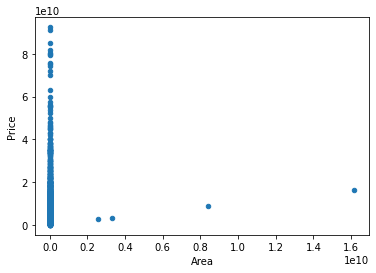

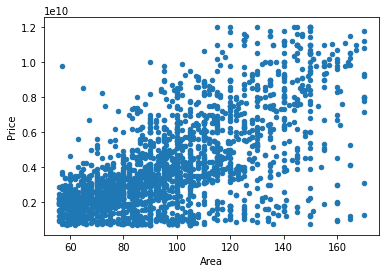

In [19]:
df.plot.scatter(x = "Area", y = "Price")

upperLimit = 0.90
lowerLimit = 1 - upperLimit

areaTrimmed = df["Area"].quantile([upperLimit, lowerLimit])
priceTrimmed = df["Price"].quantile([upperLimit, lowerLimit])
priceInDollarsTrimmed = df["Price(USD)"].quantile([upperLimit, lowerLimit])

# print(df)

df.Area = df.Area.drop(df[
    (df.Area > areaTrimmed[upperLimit]) |
    (df.Area < areaTrimmed[lowerLimit])
].index)

df.Price = df.Price.drop(df[
    (df.Price > priceTrimmed[upperLimit]) |
    (df.Price < priceTrimmed[lowerLimit])
].index)

df["Price(USD)"] = df["Price(USD)"].drop(df[
    (df["Price(USD)"] > priceInDollarsTrimmed[upperLimit]) |
    (df["Price(USD)"] < priceInDollarsTrimmed[lowerLimit])
].index)

print(df)

df = df.dropna()

print(df)
df.plot.scatter(x = "Area", y = "Price")


# Feature engineering
### i need to scale features that i use for increase model performance, avoid high output variation when i do a weight shift. For now only gonna to take areaList and pricingList as output and do feature scaling

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  


<AxesSubplot:xlabel='Area', ylabel='Price'>

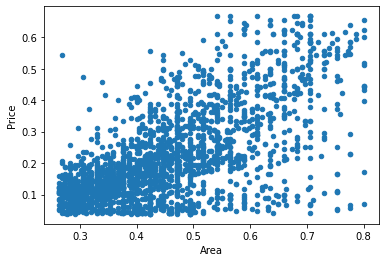

In [20]:
def scaleFeature(feature_name, dfAux, extra_scale):
    dfLocal = dfAux.loc[:,[feature_name]]

    scale = int(dfLocal.max()) / extra_scale
    df_norm = dfLocal / scale
    
    dfAux = dfAux.drop([feature_name], axis=1)
    dfAux = pd.concat((df_norm, dfAux), 1)
    
    return dfAux, scale
 
df, priceScale = scaleFeature("Price", df, 8/12)
df, priceUSDScale = scaleFeature("Price(USD)", df, 1)
df, areaScale = scaleFeature("Area", df, 8/10)
df, roomScale = scaleFeature("Room", df, 1)

# print(df.query('Area < 2/3'))
df.plot.scatter(x = "Area", y = "Price")

,Room,Area,Price(USD),Price,Parking,Warehouse,Elevator,Address
1378,0.2,0.282353,0.275000,0.183333,1,1,1,West Ferdows Boulevard
1163,0.2,0.296471,0.466667,0.311111,1,1,1,Farmanieh
2357,0.4,0.541176,0.850000,0.566667,1,1,1,Zaferanieh
2169,0.4,0.320000,0.208333,0.138889,1,1,1,East Ferdows Boulevard
1122,0.4,0.442353,0.344167,0.229444,1,1,1,Villa


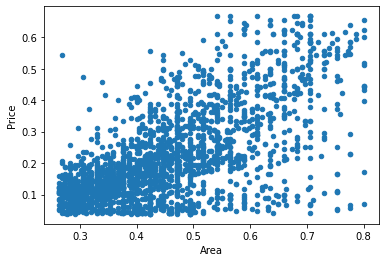

In [21]:
df.plot.scatter(x = "Area", y = "Price")
df.sample(5)

In [22]:
# house_price_Iran_Df = df.loc[0:99]
house_price_Iran_Df = df

area = house_price_Iran_Df["Area"].to_numpy()
price = house_price_Iran_Df["Price"].to_numpy()

area = area.reshape((len(area), 1))

# print(area)
# print(area[:,0])
print(area.shape)
print(price.shape)
# print(price)
print(house_price_Iran_Df.sample(5))

(2402, 1)
(2402,)
      Room      Area  Price(USD)     Price  Parking  Warehouse  Elevator  \
253    0.4  0.470588    0.250000  0.166667        1          1         1   
3146   0.6  0.588235    0.291667  0.194444        1          1         1   
735    0.6  0.691765    0.958333  0.638889        1          1         1   
1925   0.4  0.494118    0.059167  0.039444        1          1         1   
2557   0.4  0.564706    0.135000  0.090000        1          1         1   

           Address  
253   Shahr-e-Ziba  
3146      Salsabil  
735        Elahieh  
1925        Pardis  
2557      Majidieh  


# Run linear model and display its results

2022-12-21 17:53:12.990125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 17:53:13.107707: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 17:53:13.108765: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 17:53:13.110625: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
funcion-001 (Dense)          (None, 1, 1)              2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


2022-12-21 17:53:16.092354: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-21 17:53:16.092532: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-21 17:53:16.600718: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Frame: 0
81/81 [==============================] - 1s 5ms/step - loss: 0.0874 - mean_absolute_error: 0.0874 - val_loss: 0.0835 - val_mean_absolute_error: 0.0835
Frame: 1
81/81 [==============================] - 0s 3ms/step - loss: 0.0808 - mean_absolute_error: 0.0808 - val_loss: 0.0833 - val_mean_absolute_error: 0.0833
Frame: 2
81/81 [==============================] - 0s 3ms/step - loss: 0.0814 - mean_absolute_error: 0.0814 - val_loss: 0.0836 - val_mean_absolute_error: 0.0836
Frame: 3
81/81 [==============================] - 0s 3ms/step - loss: 0.0811 - mean_absolute_error: 0.0811 - val_loss: 0.0833 - val_mean_absolute_error: 0.0833
Frame: 4
81/81 [==============================] - 0s 4ms/step - loss: 0.0809 - mean_absolute_error: 0.0809 - val_loss: 0.0827 - val_mean_absolute_error: 0.0827
Frame: 5
81/81 [==============================] - 0s 4ms/step - loss: 0.0807 - mean_absolute_error: 0.0807 - val_loss: 0.0828 - val_mean_absolute_error: 0.0828
Frame: 6
81/81 [========================

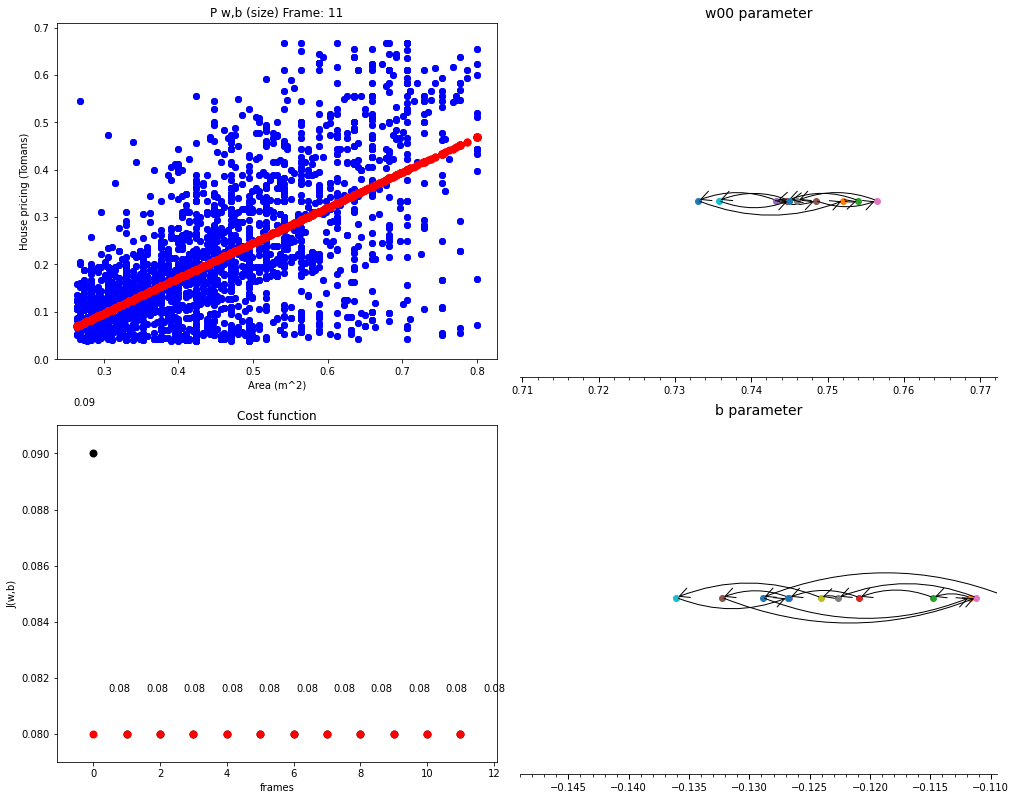

In [23]:
model=Sequential([
    Input(shape=(1, 1)),
    # Flatten(),
    Dense(units=1, activation="linear", name="funcion-{}".format("001"))
])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.009), # 0.04
    loss='mean_absolute_error',
    metrics=['mean_absolute_error'],
)
# model.fit(
#    area,
#    price,
#    epochs=8,
#    batch_size=20,
#)

for i in range(3):
        
    house_price_model = LineModel(
        # house_price_Iran_Df["Area"].values,
        id="house_price_model1",
        x_data=area,
        y_data=price,
        model=model,
        weights=[
            np.array([[-1.0]], dtype=np.float32),
            np.array([2.0], dtype=np.float32)
        ],
        frames = 12,  # 5
        animation = True,
        show_weights = True,
    )
    
    loss = house_price_model.history["loss"]
    
    if abs(loss[-1] - loss[0]) > 0.001:
        break


Video("model-{}.mp4".format(house_price_model.id))

# i will try to modify the model
### I will do the model twice accept the area of the house as input

In [24]:
print(house_price_Iran_Df["Area"].values)
print(house_price_Iran_Df["Room"].values)
print(house_price_Iran_Df.loc[:, ["Area", "Room"]].values)

[0.29647059 0.28235294 0.44705882 ... 0.40470588 0.39058824 0.49411765]
[0.2 0.2 0.4 ... 0.4 0.4 0.4]
[[0.29647059 0.2       ]
 [0.28235294 0.2       ]
 [0.44705882 0.4       ]
 ...
 [0.40470588 0.4       ]
 [0.39058824 0.4       ]
 [0.49411765 0.4       ]]


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 10)             30        
_________________________________________________________________
dense_1 (Dense)              (None, 1, 4)              44        
_________________________________________________________________
funcion-a (Dense)            (None, 1, 1)              5         
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________


2022-12-21 17:53:40.322664: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-21 17:53:40.322713: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-21 17:53:40.546853: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-21 17:53:40.547028: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Frame: 0
81/81 [==============================] - 1s 4ms/step - loss: 0.1033 - mean_absolute_error: 0.1033 - val_loss: 0.0905 - val_mean_absolute_error: 0.0905
Frame: 1
81/81 [==============================] - 0s 3ms/step - loss: 0.0913 - mean_absolute_error: 0.0913 - val_loss: 0.0829 - val_mean_absolute_error: 0.0829
Frame: 2
81/81 [==============================] - 0s 3ms/step - loss: 0.0877 - mean_absolute_error: 0.0877 - val_loss: 0.0812 - val_mean_absolute_error: 0.0812
Frame: 3
81/81 [==============================] - 0s 4ms/step - loss: 0.0874 - mean_absolute_error: 0.0874 - val_loss: 0.0800 - val_mean_absolute_error: 0.0800
Frame: 4
81/81 [==============================] - 0s 3ms/step - loss: 0.0848 - mean_absolute_error: 0.0848 - val_loss: 0.0787 - val_mean_absolute_error: 0.0787
Frame: 5
81/81 [==============================] - 0s 3ms/step - loss: 0.0841 - mean_absolute_error: 0.0841 - val_loss: 0.0803 - val_mean_absolute_error: 0.0803
Frame: 6
81/81 [========================

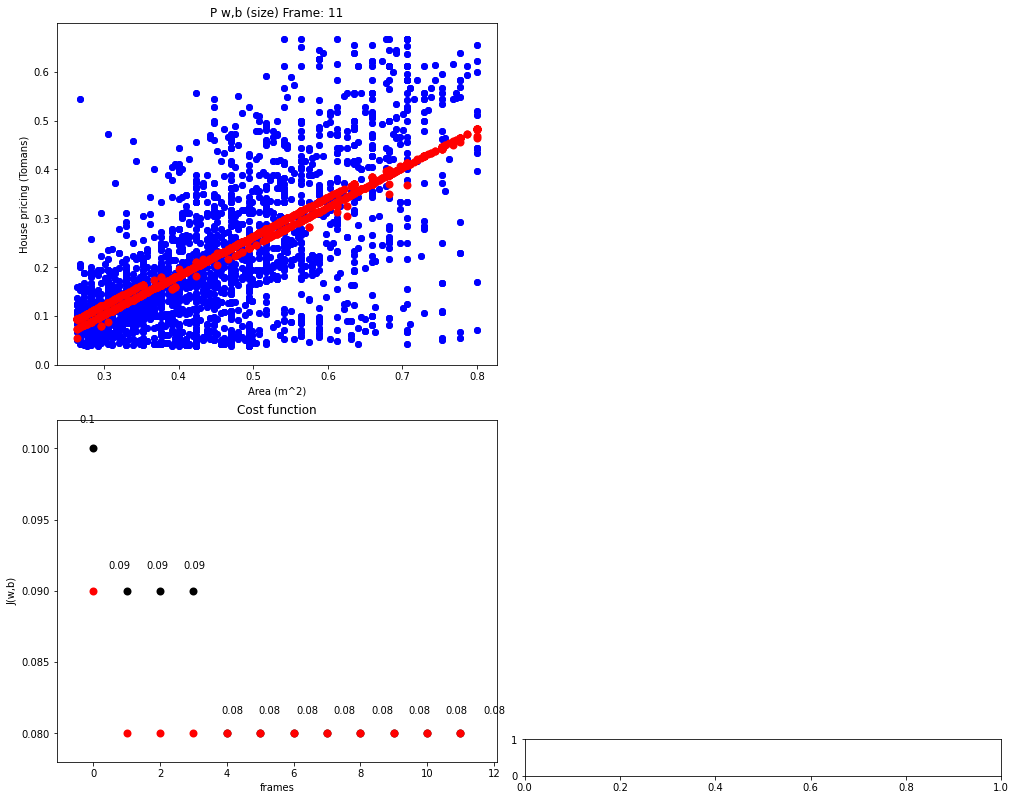

In [25]:
def inputFunction(x):
    return x

def outputFunction(y):
    y_transformed = np.matrix(y).transpose()
    return y_transformed

model = Sequential([
    Input(shape=(1, 2)),
    Dense(10, activation="relu"),
    Dense(4, activation="relu",),
    Dense(1, activation="relu", name="funcion-a"),
    # Dense(1, name='result')
])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.009), # 0.04
    loss='mean_absolute_error',
    metrics=['mean_absolute_error'],
)


for i in range(3):
    house_price_model_2 = LineModel(
        id="house_price_model_2",
        x_data=np.array(house_price_Iran_Df.loc[:, ["Area", "Room"]].values),
        y_data=house_price_Iran_Df["Price"].values,
        model = model,
        inputFunction = inputFunction,
        outputFunction = outputFunction,
        frames=12,
        animation=True,
        show_weights=False,
    )

    
    loss = house_price_model.history["loss"]
    
    if abs(loss[-1] - loss[0]) > 0.001:
        break
        
        
Video("model-{}.mp4".format(house_price_model_2.id))

# i will add Parking, Warehouse and Elevator boolean features

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
funcion-a (Dense)            (None, 1, 1)              6         
_________________________________________________________________
result (Dense)               (None, 1, 1)              2         
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


2022-12-21 17:53:55.007415: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-21 17:53:55.007468: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-21 17:53:55.239038: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-21 17:53:55.239228: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Frame: 0
81/81 [==============================] - 1s 4ms/step - loss: 0.1314 - mean_absolute_error: 0.1314 - val_loss: 0.1180 - val_mean_absolute_error: 0.1180
Frame: 1
81/81 [==============================] - 0s 3ms/step - loss: 0.1007 - mean_absolute_error: 0.1007 - val_loss: 0.1041 - val_mean_absolute_error: 0.1041
Frame: 2
81/81 [==============================] - 0s 3ms/step - loss: 0.0935 - mean_absolute_error: 0.0935 - val_loss: 0.0958 - val_mean_absolute_error: 0.0958
Frame: 3
81/81 [==============================] - 0s 5ms/step - loss: 0.0869 - mean_absolute_error: 0.0869 - val_loss: 0.0907 - val_mean_absolute_error: 0.0907
Frame: 4
81/81 [==============================] - 0s 3ms/step - loss: 0.0823 - mean_absolute_error: 0.0823 - val_loss: 0.0865 - val_mean_absolute_error: 0.0865
Frame: 5
81/81 [==============================] - 0s 3ms/step - loss: 0.0801 - mean_absolute_error: 0.0801 - val_loss: 0.0835 - val_mean_absolute_error: 0.0835
Frame: 6
81/81 [========================

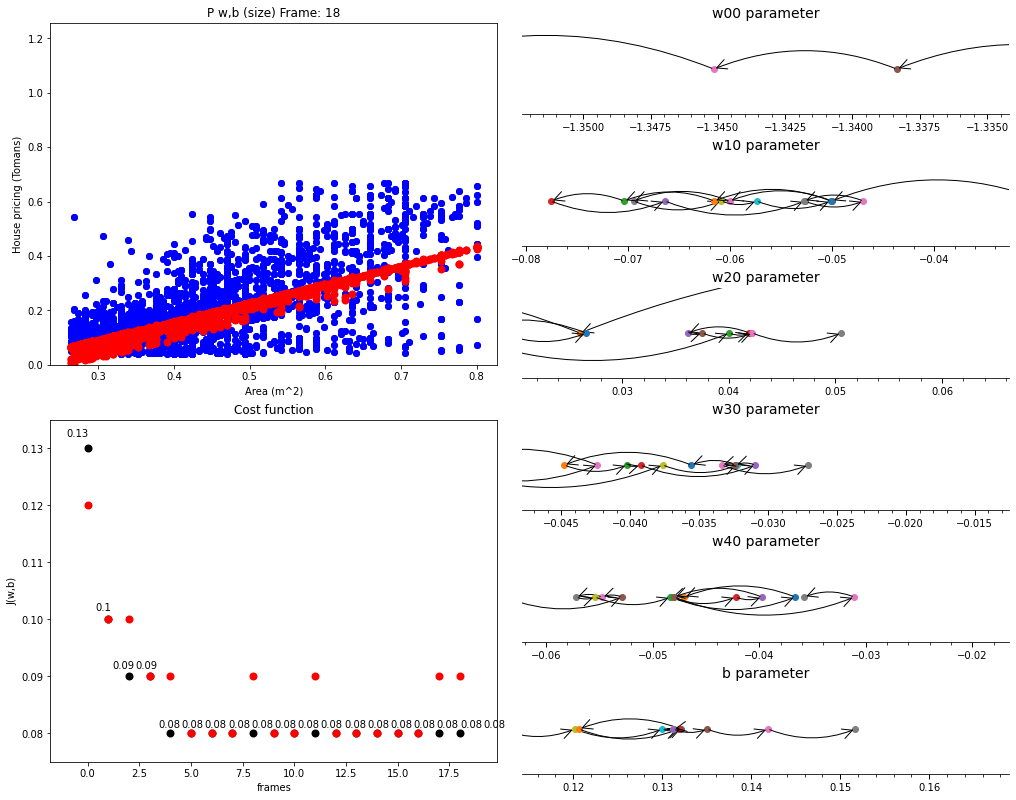

In [26]:
def inputFunction(x):
    return x

def outputFunction(y):
    y_transformed = np.matrix(y).transpose()
    return y_transformed

model = Sequential([
    Input(shape=(1, 5)),
    Dense(1, activation="linear", name="funcion-a"),
    Dense(1, name='result')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.009), # 0.04
    loss='mean_absolute_error',
    metrics=['mean_absolute_error'],
)

house_price_model_3 = LineModel(
    id="house_price_model_3",
    x_data=np.array(house_price_Iran_Df.loc[:, ["Area", "Parking", "Room", "Warehouse", "Elevator"]].values),
    y_data=house_price_Iran_Df["Price"].values,
    model = model,
    # inputFunction = lambda x : np.array([x, x], dtype=np.float32)
    inputFunction = inputFunction,
    outputFunction = outputFunction,
    frames=19,
    animation=True,
    show_weights=True,
)
Video("model-{}.mp4".format(house_price_model_3.id))

# Model test

In [27]:
w = house_price_model.model.get_weights()[0].item((0, 0))
b = house_price_model.model.get_weights()[1].item((0))

print("{} * x' + {} = y'".format(w, b))
print("y' = y / {}".format(10 * priceScale))
print("x' = x / {}".format(10 * areaScale))
print()

print("then,")
print("({} * x / {}) + {} = y / {}".format(w, 10*areaScale, b, 10*priceScale))
print()

print("then,")
print("{} * x + {} = {} * y".format(w / (10 * areaScale), b , 1 /(10 * priceScale)))

print("then,")
print("{} * x + {} = {} * y".format((10 * priceScale) * w / (10 * areaScale), (10 * priceScale) * b , 1))

0.7449908256530762 * x' + -0.12683899700641632 = y'
y' = y / 180000000000.0
x' = x / 2125.0

then,
(0.7449908256530762 * x / 2125.0) + -0.12683899700641632 = y / 180000000000.0

then,
0.0003505839179543888 * x + -0.12683899700641632 = 5.5555555555555555e-12 * y
then,
63105105.231789984 * x + -22831019461.154938 = 1 * y


In [28]:
print("{} * areaScale + {} = pricingHouseInUSD".format(
    (priceScale * w) / (areaScale * tomansToDollarsScale),
    (b * priceScale) / tomansToDollarsScale
))

2103.503511558639 * areaScale + -76103.39834250015 = pricingHouseInUSD


# First approximation house price prediction with area size alone
### the price of the house rises 2180 USD (+- 140) for each increase in area up to 1 m**2

### 1 USD = 30,000 Tomans (in extra info at house price dataset).

# I will try with an example

In [29]:
df = house_price_Iran_Df
df["Area"] = df["Area"] * areaScale
df["Room"] = df["Room"] * roomScale
df["Price"] = df["Price"] * priceScale
df["Price(USD)"] = df["Price(USD)"] * priceUSDScale

# Scale list variable
* priceScale
* priceUSDScale
* areaScale
* roomScale

In [30]:
example = df.loc[30:60]
print(example)

    Room   Area  Price(USD)         Price  Parking  Warehouse  Elevator  \
30   2.0   90.0    50000.00  1.500000e+09        0          1         0   
32   2.0   96.0   262400.00  7.872000e+09        1          1         1   
33   2.0   67.0    78333.33  2.350000e+09        1          1         0   
34   2.0   68.0    83333.33  2.500000e+09        1          1         1   
35   1.0   62.0    71666.67  2.150000e+09        1          0         1   
37   2.0  110.0   125000.00  3.750000e+09        1          1         1   
38   2.0  129.0   175000.00  5.250000e+09        1          1         1   
39   2.0  109.0   161000.00  4.830000e+09        1          1         1   
40   1.0   58.0   113333.33  3.400000e+09        1          1         1   
42   2.0  150.0    40000.00  1.200000e+09        0          1         1   
44   3.0  130.0   166666.67  5.000000e+09        1          1         0   
45   2.0   88.0   158333.33  4.750000e+09        1          1         1   
47   3.0  113.0   233333.

In [31]:
example["Area"] = example["Area"] / areaScale
example["Room"] = example["Room"] / roomScale
example["Price"] = example["Price"] / priceScale
example["Price(USD)"] = example["Price(USD)"] / priceUSDScale

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [32]:
print(example)

    Room      Area  Price(USD)     Price  Parking  Warehouse  Elevator  \
30   0.4  0.423529    0.125000  0.083333        0          1         0   
32   0.4  0.451765    0.656000  0.437333        1          1         1   
33   0.4  0.315294    0.195833  0.130556        1          1         0   
34   0.4  0.320000    0.208333  0.138889        1          1         1   
35   0.2  0.291765    0.179167  0.119444        1          0         1   
37   0.4  0.517647    0.312500  0.208333        1          1         1   
38   0.4  0.607059    0.437500  0.291667        1          1         1   
39   0.4  0.512941    0.402500  0.268333        1          1         1   
40   0.2  0.272941    0.283333  0.188889        1          1         1   
42   0.4  0.705882    0.100000  0.066667        0          1         1   
44   0.6  0.611765    0.416667  0.277778        1          1         0   
45   0.4  0.414118    0.395833  0.263889        1          1         1   
47   0.6  0.531765    0.583333  0.3888

# example error

In [33]:
print("house_price_model", np.mean(house_price_model.call(np.array([
    example.Area
]).reshape((-1, 1)))).mean() * priceScale / tomansToDollarsScale)

print("house_price_model_2", house_price_model_2.call(np.array([
    example.Area, example.Room
]).reshape(-1, 2)).mean() * priceScale / tomansToDollarsScale)

print("house_price_model_3", house_price_model_3.call(np.array([
    example.Area, example.Parking, example.Room, example.Warehouse, example.Elevator
]).reshape((-1,5))).mean() * priceScale / tomansToDollarsScale)


house_price_model 122266.12888200111
house_price_model_2 117357.13205260775
house_price_model_3 213075.7037706879


In [34]:
print("house_price_model", np.mean(house_price_model.call(np.array([
    example.Area
]).reshape((-1, 1))).reshape((-1)) - example.Price) * priceScale / tomansToDollarsScale)

print("house_price_model_2", np.mean(house_price_model_2.call(np.array([
    example.Area, example.Room
]).reshape((-1, 2))).reshape((-1)) - example.Price) * priceScale / tomansToDollarsScale)

print("house_price_model_3", np.mean(house_price_model_3.call(np.array([
    example.Area, example.Parking, example.Room, example.Warehouse, example.Elevator
]).reshape((-1,5))).reshape((-1)) - example.Price)  * priceScale / tomansToDollarsScale)

house_price_model -4410.683331716177
house_price_model_2 -9319.67433022038
house_price_model_3 86398.90827218625


### In this example, the model 1 and 2 are better than the 3th model.

<h1> I will predict house price with other dataset with more information</h1>

<p>/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv</p>
<p>/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt</p>
<p>/kaggle/input/house-prices-advanced-regression-techniques/train.csv</p>
<p>/kaggle/input/house-prices-advanced-regression-techniques/test.cs</p>

In [35]:
dataset_advanced_regression = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
len(dataset_advanced_regression)

1460

In [36]:
dataset_advanced_regression.sample(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1046,1047,60,RL,85.0,16056,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,New,Partial,556581
412,413,20,FV,NaN,4403,Pave,NaN,IR2,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,New,Partial,222000
266,267,60,RL,70.0,11207,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,185000
300,301,190,RL,90.0,15750,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,157000
402,403,30,RL,60.0,10200,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,NaN,0,8,2008,WD,Normal,108000


In [37]:
dataset_advanced_regression.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

<h2> i will verificate types </h2>

In [38]:
dataset_advanced_regression.loc[:,["LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle"]].value_counts(dropna=False)

LotShape  LandContour  Utilities  LotConfig  LandSlope  Neighborhood  Condition1  Condition2  BldgType  HouseStyle
Reg       Lvl          AllPub     Inside     Gtl        NAmes         Norm        Norm        1Fam      1Story        68
                                                        CollgCr       Norm        Norm        1Fam      1Story        31
IR1       Lvl          AllPub     Inside     Gtl        NAmes         Norm        Norm        1Fam      1Story        27
Reg       Lvl          AllPub     Inside     Gtl        CollgCr       Norm        Norm        1Fam      2Story        23
IR1       Lvl          AllPub     Inside     Gtl        Gilbert       Norm        Norm        1Fam      2Story        21
                                                                                                                      ..
                                             Mod        Mitchel       Norm        Norm        1Fam      2Story         1
                                      

In [39]:
dataset_advanced_regression.loc[:,["RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType"]].value_counts(dropna=False)

RoofStyle  RoofMatl  Exterior1st  Exterior2nd  MasVnrType
Gable      CompShg   VinylSd      VinylSd      None          214
                                               BrkFace       130
                     MetalSd      MetalSd      None          129
                     Wd Sdng      Wd Sdng      None          116
                     HdBoard      HdBoard      None           71
                                                            ... 
                     VinylSd      Stucco       None            1
                                  Plywood      Stone           1
                                               None            1
                                  Other        BrkFace         1
Shed       WdShake   Plywood      Plywood      None            1
Length: 160, dtype: int64

<h2> I will do not delete None values because the None value can introduce some value of the training model </h2> 

In [40]:
dataset_advanced_regression.loc[:,["ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2"]].value_counts(dropna=False)

ExterQual  ExterCond  Foundation  BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
Gd         TA         PConc       Gd        TA        No            GLQ           Unf             94
                                                                    Unf           Unf             80
TA         TA         CBlock      TA        TA        No            Rec           Unf             56
                                                                    Unf           Unf             54
Gd         TA         PConc       Gd        TA        Av            GLQ           Unf             51
                                                                                                  ..
TA         Gd         BrkTil      TA        TA        Mn            LwQ           Unf              1
                                            Gd        No            ALQ           Unf              1
                                                      Mn            Rec           ALQ            

In [41]:
dataset_advanced_regression.loc[:,["GarageYrBlt", "GarageFinish"]].value_counts(dropna=False)

GarageYrBlt  GarageFinish
NaN          NaN             81
2006.0       RFn             37
2005.0       Fin             36
2007.0       Fin             28
1950.0       Unf             24
                             ..
1981.0       RFn              1
1983.0       Fin              1
1986.0       RFn              1
1987.0       Fin              1
1974.0       Fin              1
Length: 216, dtype: int64

<h2> How we can see these are cathegorical variables and verify if i need to add this or put zero to this features or leave to stay null</h2> 

In [42]:
print(dataset_advanced_regression.query("LotFrontage==0").loc[:,"LotFrontage"])
print(dataset_advanced_regression.query("MasVnrArea==0").loc[:,"MasVnrArea"])
print(dataset_advanced_regression.query("GarageYrBlt==0").loc[:,"GarageYrBlt"])

Series([], Name: LotFrontage, dtype: float64)
1       0.0
3       0.0
5       0.0
8       0.0
9       0.0
       ... 
1454    0.0
1455    0.0
1457    0.0
1458    0.0
1459    0.0
Name: MasVnrArea, Length: 861, dtype: float64
Series([], Name: GarageYrBlt, dtype: float64)


In [43]:
dataset_advanced_regression_only_numbers = pd.get_dummies(dataset_advanced_regression, dummy_na=True)

In [44]:
dataset_advanced_regression_only_numbers.info(verbose=True, null_counts=True) # [939]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 333 columns):
 #    Column                 Non-Null Count  Dtype  
---   ------                 --------------  -----  
 0    Id                     1460 non-null   int64  
 1    MSSubClass             1460 non-null   int64  
 2    LotFrontage            1201 non-null   float64
 3    LotArea                1460 non-null   int64  
 4    OverallQual            1460 non-null   int64  
 5    OverallCond            1460 non-null   int64  
 6    YearBuilt              1460 non-null   int64  
 7    YearRemodAdd           1460 non-null   int64  
 8    MasVnrArea             1452 non-null   float64
 9    BsmtFinSF1             1460 non-null   int64  
 10   BsmtFinSF2             1460 non-null   int64  
 11   BsmtUnfSF              1460 non-null   int64  
 12   TotalBsmtSF            1460 non-null   int64  
 13   1stFlrSF               1460 non-null   int64  
 14   2ndFlrSF               1460 non-null  

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


In [45]:
dataset_advanced_regression_only_numbers["LotFrontage_nan"] = dataset_advanced_regression_only_numbers.loc[:,"LotFrontage"].isnull().astype(int)
dataset_advanced_regression_only_numbers["MasVnrArea_nan"] = dataset_advanced_regression_only_numbers.loc[:,"MasVnrArea"].isnull().astype(int)

print(dataset_advanced_regression_only_numbers.loc[:,["LotFrontage","LotFrontage_nan", "MasVnrArea", "MasVnrArea_nan"]].sample(10))


      LotFrontage  LotFrontage_nan  MasVnrArea  MasVnrArea_nan
834          75.0                0       136.0               0
807         144.0                0         0.0               0
18           66.0                0         0.0               0
1066         59.0                0         0.0               0
330           NaN                1        84.0               0
367         101.0                0       305.0               0
25          110.0                0       640.0               0
1329         63.0                0         0.0               0
808          85.0                0      1047.0               0
258          80.0                0       172.0               0


In [46]:
dataset_advanced_regression_only_numbers["LotFrontage"] = dataset_advanced_regression_only_numbers.loc[:,"LotFrontage"].fillna(dataset_advanced_regression_only_numbers.loc[:,"LotFrontage"].mean()) # mean doesnt affect the general prediction
dataset_advanced_regression_only_numbers["MasVnrArea"] = dataset_advanced_regression_only_numbers.loc[:,"MasVnrArea"].fillna(dataset_advanced_regression_only_numbers.loc[:,"MasVnrArea"].mean())
# dataset_advanced_regression_only_numbers["GarageYrBlt"] = dataset_advanced_regression_only_numbers.loc[:,"GarageYrBlt"].fillna(dataset_advanced_regression_only_numbers.loc[:,"GarageYrBlt"].mean())
# 

In [47]:
dataset_advanced_regression["Alley"].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

<AxesSubplot:>

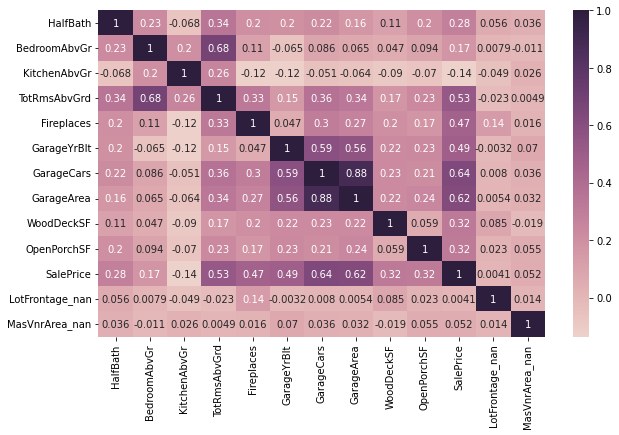

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
# .loc[:,["BsmtUnfSF", "KitchenAbvGr"]]

sns.heatmap(dataset_advanced_regression_only_numbers.iloc[:,np.r_[20:30, 37, 333, 334]].corr(), ax=ax, annot=True, cmap=sns.cubehelix_palette(as_cmap=True))

<h2> i will use LotFrontage, LotArea, LotFrontage_nan and LotArea_nan to predict SalePrice because exists a correlation between SalePrice and these features </h2>

In [49]:
first_database_implementation = dataset_advanced_regression_only_numbers.loc[:, [
    "LotArea",
    "MSSubClass",
    "LotFrontage",
    "MasVnrArea",
    "MasVnrArea_nan",
    "LotFrontage_nan",
    "YearBuilt",
    "YearRemodAdd",
    "BsmtFinSF1",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "GrLivArea",
    "BsmtFullBath",
    "FullBath",
    "SalePrice"
]]

In [50]:
print(first_database_implementation.info())
first_database_implementation.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   LotArea          1460 non-null   int64  
 1   MSSubClass       1460 non-null   int64  
 2   LotFrontage      1460 non-null   float64
 3   MasVnrArea       1460 non-null   float64
 4   MasVnrArea_nan   1460 non-null   int64  
 5   LotFrontage_nan  1460 non-null   int64  
 6   YearBuilt        1460 non-null   int64  
 7   YearRemodAdd     1460 non-null   int64  
 8   BsmtFinSF1       1460 non-null   int64  
 9   TotalBsmtSF      1460 non-null   int64  
 10  1stFlrSF         1460 non-null   int64  
 11  2ndFlrSF         1460 non-null   int64  
 12  GrLivArea        1460 non-null   int64  
 13  BsmtFullBath     1460 non-null   int64  
 14  FullBath         1460 non-null   int64  
 15  SalePrice        1460 non-null   int64  
dtypes: float64(2), int64(14)
memory usage: 182.6 KB
None


,LotArea,MSSubClass,LotFrontage,MasVnrArea,MasVnrArea_nan,LotFrontage_nan,YearBuilt,YearRemodAdd,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,SalePrice
837,1680,160,21.000000,158.0,0,0,1973,1973,330,483,483,504,987,1,1,100000
1014,11664,20,60.000000,206.0,0,0,1948,1950,336,1082,1082,0,1082,0,1,119200
704,8400,20,70.000000,109.0,0,0,2004,2005,712,1473,1484,0,1484,1,2,213000
81,4500,120,32.000000,443.0,0,0,1998,1998,1201,1237,1337,0,1337,1,2,153500
76,8475,20,70.049958,0.0,0,1,1956,1956,228,952,952,0,952,0,1,135750


In [51]:
first_database_implementation["SquareLotArea"] = first_database_implementation["LotArea"] ** 2
first_database_implementation["LotAreaDotLotFrontage"] = first_database_implementation["LotArea"] * first_database_implementation["LotFrontage"]

In [52]:
first_database_implementation = first_database_implementation[[
    "LotArea",
    "SquareLotArea","LotAreaDotLotFrontage", # 
    "MSSubClass",
    "LotFrontage",
    "MasVnrArea_nan",
    "LotFrontage_nan",
    "YearBuilt",
    "YearRemodAdd",
    "BsmtFinSF1",
    "TotalBsmtSF",
    "1stFlrSF",
    "2ndFlrSF",
    "GrLivArea",
    "BsmtFullBath",
    "FullBath",
    "SalePrice"
]]

# I will trimmed out unusual features values again.

In [53]:
upper_limit = 0.90
lower_limit = 1 - upperLimit

lot_area_trim = first_database_implementation["LotArea"].quantile([upperLimit, lowerLimit])
square_lot_area_trim = first_database_implementation["SquareLotArea"].quantile([upperLimit, lowerLimit])
lot_frontage_trim = first_database_implementation["LotFrontage"].quantile([upperLimit, lowerLimit])

def cut_dataframe(df, feature, trim_list):
    df[feature] = df[feature].drop(df[
        (df[feature] > trim_list[upper_limit]) |
        (df[feature] < trim_list[lower_limit])
    ].index)
    return df

first_database_implementation = cut_dataframe(first_database_implementation, "LotArea", lot_area_trim)
first_database_implementation = cut_dataframe(first_database_implementation, "SquareLotArea", square_lot_area_trim)
first_database_implementation = cut_dataframe(first_database_implementation, "LotFrontage", lot_frontage_trim)

first_database_implementation = first_database_implementation.dropna()

In [54]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X=first_database_implementation.values[:,0:-1]
y=first_database_implementation.values[:,-1]

print(X)
print(f"shape: {X.shape}")
print()
print(y)
print(f"shape: {y.shape}")


[[8.4500000e+03 7.1402500e+07 5.4925000e+05 ... 1.7100000e+03
  1.0000000e+00 2.0000000e+00]
 [9.6000000e+03 9.2160000e+07 7.6800000e+05 ... 1.2620000e+03
  0.0000000e+00 2.0000000e+00]
 [1.1250000e+04 1.2656250e+08 7.6500000e+05 ... 1.7860000e+03
  1.0000000e+00 2.0000000e+00]
 ...
 [9.0420000e+03 8.1757764e+07 5.9677200e+05 ... 2.3400000e+03
  0.0000000e+00 2.0000000e+00]
 [9.7170000e+03 9.4420089e+07 6.6075600e+05 ... 1.0780000e+03
  1.0000000e+00 1.0000000e+00]
 [9.9370000e+03 9.8743969e+07 7.4527500e+05 ... 1.2560000e+03
  1.0000000e+00 1.0000000e+00]]
shape: (1040, 16)

[208500. 181500. 223500. ... 266500. 142125. 147500.]
shape: (1040,)


<h2> I will turn left and then will normalize by row and will turn right </h2>
<p> i do that because sklearn doesnt allow to normalize by column </p>

In [55]:
# qt = preprocessing.QuantileTransformer(random_state=0)
# qt.fit_transform(X)
min_max_scaler = preprocessing.MinMaxScaler()
X_transformed = min_max_scaler.fit_transform(X)

transform_normalize = preprocessing.Normalizer(norm="max")
y_transformed = transform_normalize.fit_transform(y.reshape(1, -1)).reshape((-1, 1))


# X_transformed = np.transpose(X)

# transform_normalize = preprocessing.Normalizer(norm="l2")
# X_transformed = transform_normalize.transform(X_transformed)

# X_transformed = np.transpose(X_transformed)

# y_transformed = transform_normalize.transform(y.reshape(1,-1)).reshape((-1))

print(X_transformed[0:10])
print(X_transformed.shape)

print(y_transformed[0:10])
print(y_transformed.shape)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_transformed, test_size=0.20, shuffle=True)

[[0.368      0.25546323 0.28457368 0.23529412 0.37209302 0.
  0.         0.94927536 0.88333333 0.41627358 0.26699938 0.18037319
  0.53010552 0.44201735 0.33333333 0.66666667]
 [0.49066667 0.36974108 0.49259538 0.         0.72093023 0.
  0.         0.75362319 0.43333333 0.57665094 0.39363693 0.32066344
  0.         0.29810472 0.         0.66666667]
 [0.66666667 0.55913978 0.48974251 0.23529412 0.44186047 0.
  0.         0.93478261 0.86666667 0.2865566  0.28696195 0.20248791
  0.53755431 0.4664311  0.33333333 0.66666667]
 [0.48533333 0.36446968 0.30715889 0.29411765 0.25581395 0.
  0.         0.3115942  0.33333333 0.12735849 0.23580786 0.21665515
  0.46927374 0.44426598 0.33333333 0.33333333]
 [0.98773333 0.98187066 0.90135445 0.23529412 0.81395349 0.
  0.         0.92753623 0.83333333 0.38620283 0.35714286 0.28023497
  0.65363128 0.59877931 0.33333333 0.66666667]
 [0.97226667 0.95921948 0.90319455 0.17647059 0.8372093  0.
  0.         0.87681159 0.75       0.43160377 0.24828447 0.159640

In [56]:
X_test

array([[0.43402667, 0.31516496, 0.39182919, ..., 0.2126566 , 0.33333333,
        0.33333333],
       [0.60885333, 0.493619  , 0.47556846, ..., 0.49245101, 0.33333333,
        0.33333333],
       [0.55029333, 0.4305495 , 0.56410444, ..., 0.51590106, 0.33333333,
        0.66666667],
       ...,
       [0.49066667, 0.36974108, 0.31001176, ..., 0.46257629, 0.33333333,
        0.66666667],
       [0.37194667, 0.25891327, 0.2707192 , ..., 0.3745583 , 0.        ,
        0.66666667],
       [0.29866667, 0.19731269, 0.24439578, ..., 0.18149695, 0.        ,
        0.33333333]])

In [57]:
def run(model, X, y, X_test,  y_test):
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.03),
        loss=tf.keras.losses.MeanAbsoluteError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )
    model.save_weights('aux_model.h5')
    
    for i in range(3):        
        model.summary()
        model.load_weights('aux_model.h5')
        model.fit(
            X,
            y,
            epochs=12,
            batch_size=35,
            validation_data=(X_test,  y_test),
        )
        loss = model.history.history["loss"]

        if abs(loss[-1] - loss[0]) > 0.001:
            break

    return model

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1, 2)),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="relu"),
    # tf.keras.layers.Dense(1, activation="relu"),
])

model_trained = run(model, X_train[:,0:2], y_train, X_test[:,0:2],  y_test)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1, 10)             30        
_________________________________________________________________
dense_3 (Dense)              (None, 1, 1)              11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
24/24 [==============================] - 0s 7ms/step - loss: 0.3638 - mean_squared_error: 0.1515 - val_loss: 0.3688 - val_mean_squared_error: 0.1563
Epoch 2/12
24/24 [==============================] - 0s 3ms/step - loss: 0.3638 - mean_squared_error: 0.1515 - val_loss: 0.3688 - val_mean_squared_error: 0.1563
Epoch 3/12
24/24 [==============================] - 0s 3ms/step - loss: 0.3638 - mean_squared_error: 0.1515 - val_loss: 0.3688 - val_mean_squared_error: 0.1563
Epoch 4/12
24/24 [======================

In [58]:
model_with_four_variables = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1, 16)),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="relu"),
    # tf.keras.layers.Dense(1, activation="relu"),
])
run(model_with_four_variables, X_train, y_train, X_test,  y_test)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1, 10)             170       
_________________________________________________________________
dense_5 (Dense)              (None, 1, 10)             110       
_________________________________________________________________
dense_6 (Dense)              (None, 1, 1)              11        
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
24/24 [==============================] - 0s 7ms/step - loss: 0.3637 - mean_squared_error: 0.1515 - val_loss: 0.3688 - val_mean_squared_error: 0.1563
Epoch 2/12
24/24 [==============================] - 0s 4ms/step - loss: 0.3637 - mean_squared_error: 0.1515 - val_loss: 0.3688 - val_mean_squared_error: 0.1563
Epoch 3/12
24/24 [==============================] - 0s 4ms/step - 

## For plot model result, i will compact all dimensions in only LotArea and SalePrice parameters, i will see the shade of the function
#### i was decide to hide weights change graphs because it is not possible to read what is the algorithm doing and is slowly

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1, 10)             170       
_________________________________________________________________
dense_8 (Dense)              (None, 1, 4)              44        
_________________________________________________________________
dense_9 (Dense)              (None, 1, 1)              5         
Total params: 219
Trainable params: 219
Non-trainable params: 0
_________________________________________________________________


2022-12-21 17:55:05.568860: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-21 17:55:05.569424: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-21 17:55:05.855515: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-21 17:55:05.855727: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Frame: 0
28/28 [==============================] - 1s 7ms/step - loss: 0.1113 - mean_absolute_error: 0.1113 - val_loss: 0.0802 - val_mean_absolute_error: 0.0802
Frame: 1
28/28 [==============================] - 0s 4ms/step - loss: 0.0805 - mean_absolute_error: 0.0805 - val_loss: 0.0874 - val_mean_absolute_error: 0.0874
Frame: 2
28/28 [==============================] - 0s 4ms/step - loss: 0.0732 - mean_absolute_error: 0.0732 - val_loss: 0.0654 - val_mean_absolute_error: 0.0654
Frame: 3
28/28 [==============================] - 0s 4ms/step - loss: 0.0667 - mean_absolute_error: 0.0667 - val_loss: 0.0716 - val_mean_absolute_error: 0.0716
Frame: 4
28/28 [==============================] - 0s 4ms/step - loss: 0.0715 - mean_absolute_error: 0.0715 - val_loss: 0.0679 - val_mean_absolute_error: 0.0679
Frame: 5
28/28 [==============================] - 0s 4ms/step - loss: 0.0624 - mean_absolute_error: 0.0624 - val_loss: 0.0857 - val_mean_absolute_error: 0.0857
Frame: 6
28/28 [========================

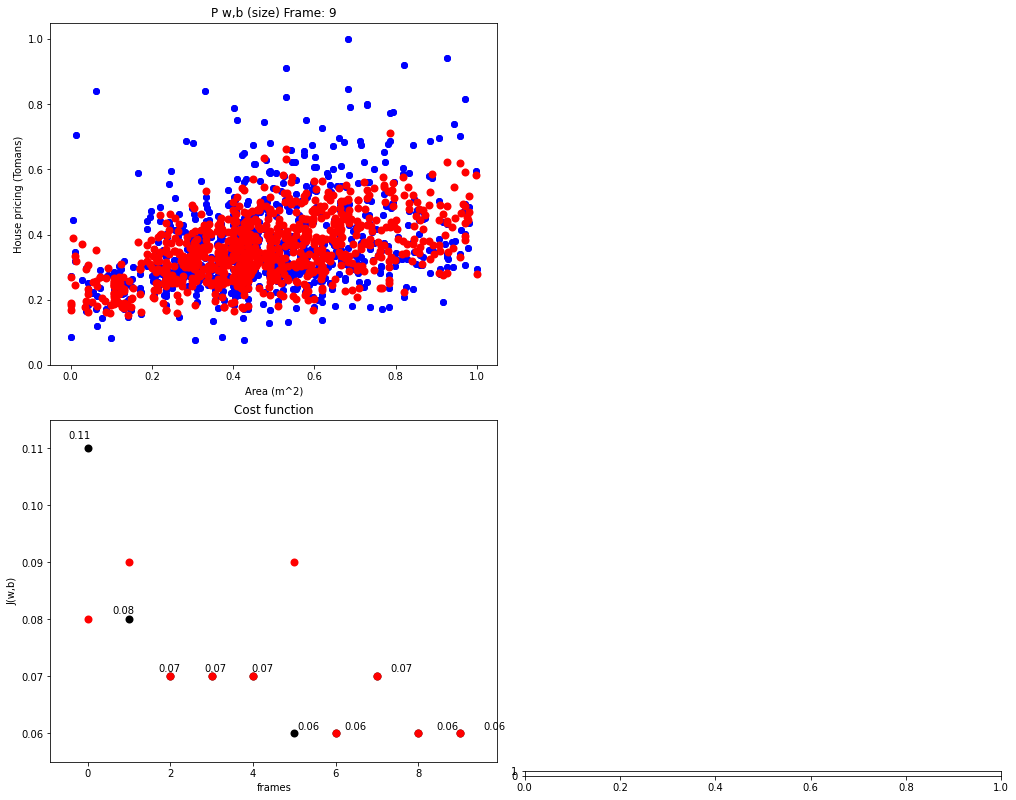

In [59]:
identity_initializer = tf.keras.initializers.Identity()

model_with_four_variables = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(1, 16)),
    tf.keras.layers.Dense(10, activation="relu"),    
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="relu"),
])

model_with_four_variables.compile(
    #optimizer=tf.keras.optimizers.Adam(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.06),
    loss=tf.keras.losses.MeanAbsoluteError(),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

for i in range(3):
    house_price_model_advanced = LineModel(
        id="house_price_advanced",
        x_data=X_train,
        y_data=y_train,
        model = model_with_four_variables,
        # inputFunction = inputFunction,
        # outputFunction = outputFunction,
        frames=10,
        animation=True,
        show_weights=False,
    )
    loss = house_price_model_advanced.history["loss"]
    
    if abs(loss[-1] - loss[0]) > 0.001:
        break


Video("model-{}.mp4".format(house_price_model_advanced.id))

## It doesnt mean that the algorithm works well
### This plot show us that the shade of house_price_model_advanced is the same shade of the training set getting only two parameters of all parameters, house area and price.
## Then, how we can verify that the model function represents the training set?
### We will try to get others parameters and see that the shade is the same that the shade of the model in that dimensions, i will do math ortogonal projection of the function to the two features plane all that n times.
(Or we can create an image that randomly change the ) 

### Note: First of all we would like to see that the model works well in the training set, later we will see if the model works with data that doesnt have seen before.

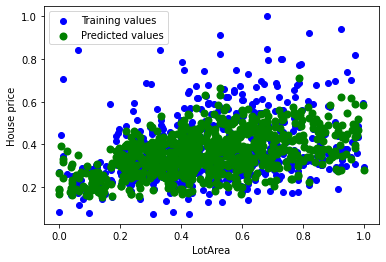

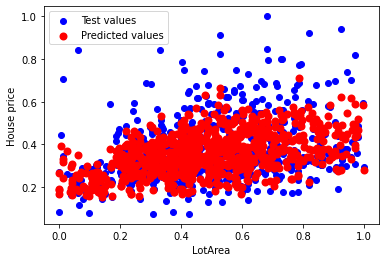

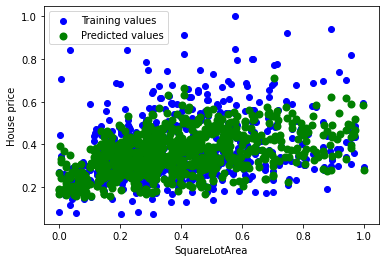

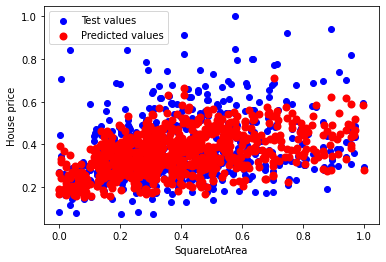

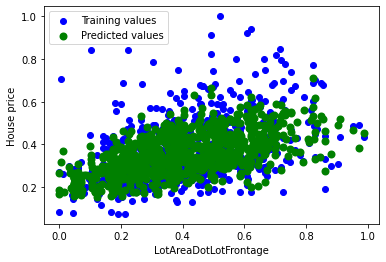

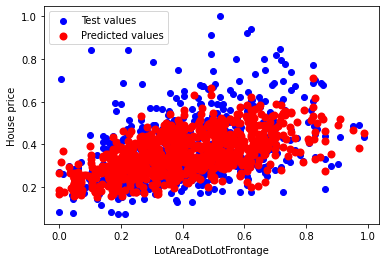

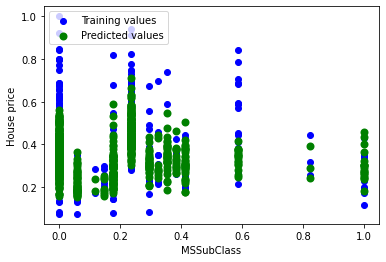

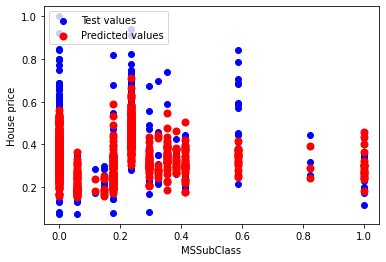

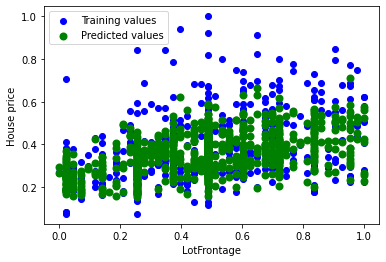

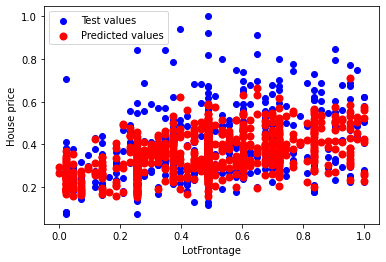

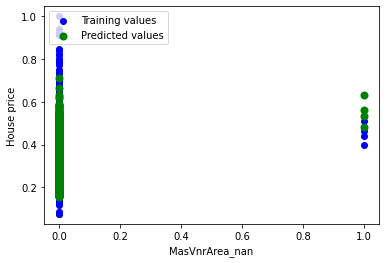

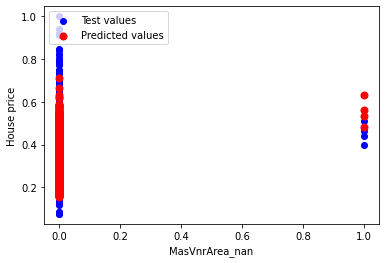

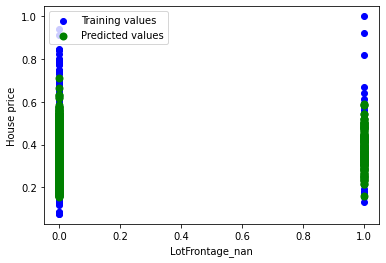

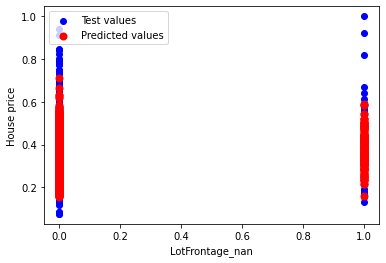

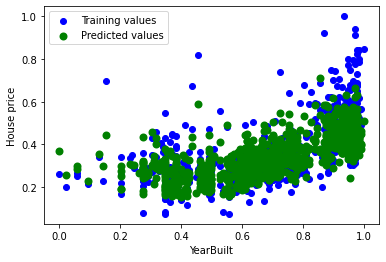

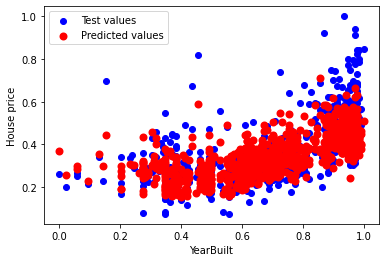

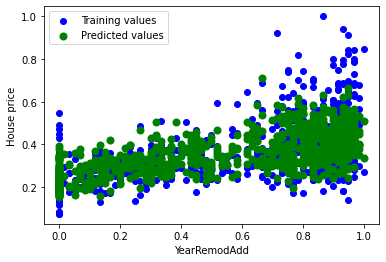

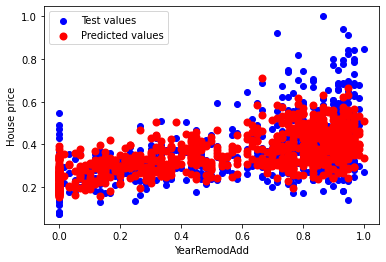

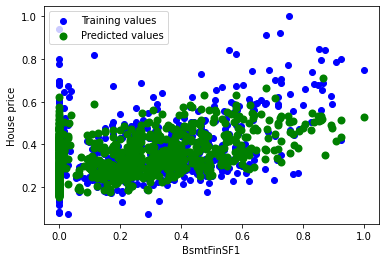

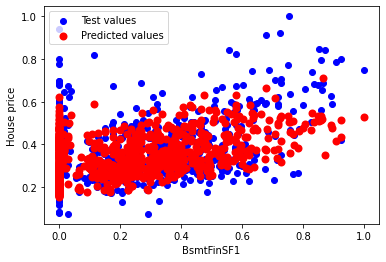

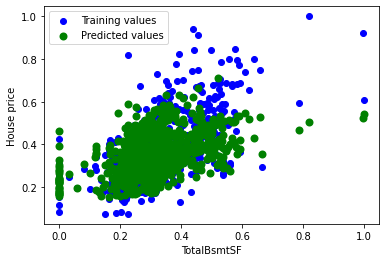

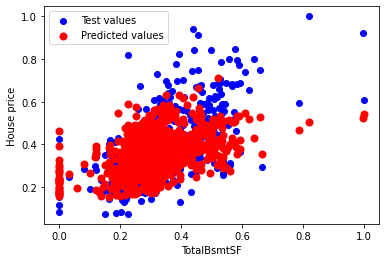

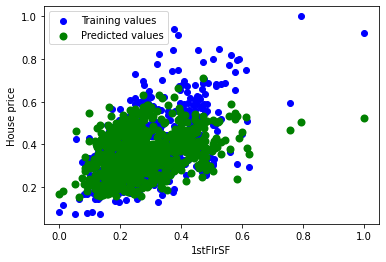

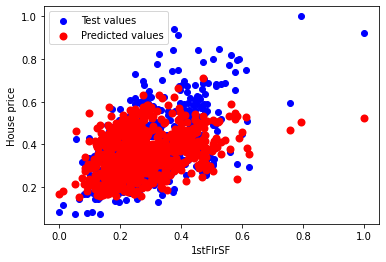

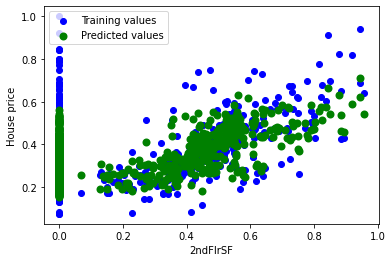

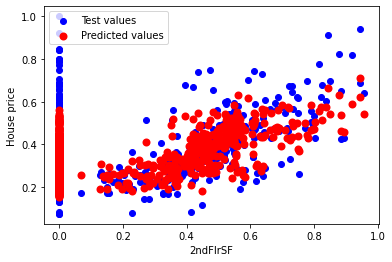

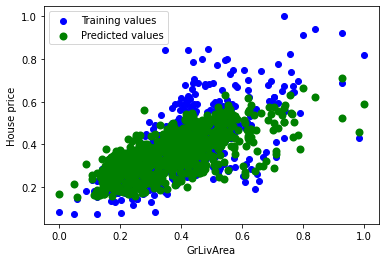

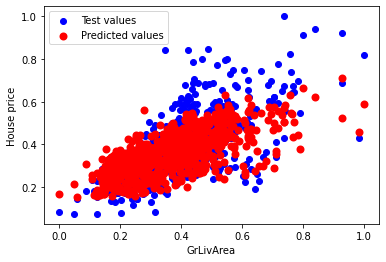

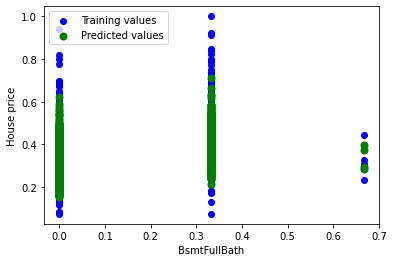

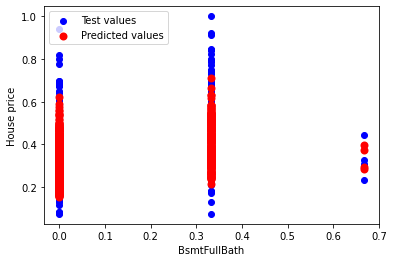

In [60]:
def get_plot(model, feature_idx, X_train, y_train, columns_dataframe, color_predicted, label_dataset_value):
    
    plt.scatter(X_train[:,feature_idx], y_train, color="blue", label=label_dataset_value)
    plt.scatter(X_train[:,feature_idx], model.predict(X_train), color=color_predicted, lw=2, label='Predicted values')
    
    plt.xlabel(columns_dataframe[feature_idx])
    plt.ylabel('House price')
    plt.legend(loc="upper left")

    plt.show()
    
for feature_idx in range(0, X.shape[1] - 1):
    get_plot(
        model_with_four_variables,
        feature_idx,
        X_train,
        y_train,
        first_database_implementation.columns[0:-1],
        color_predicted="green",
        label_dataset_value="Training values"
    )
    
    # the next plot is red because this plot show us that the model can generalize well or not
    get_plot(
        model_with_four_variables,
        feature_idx,
        X_train,
        y_train,
        first_database_implementation.columns[0:-1],
        color_predicted="red",
        label_dataset_value="Test values"
    )


In [61]:
import IPython.display as ipd


beep = np.sin(1*np.pi*400*np.arange(10000*1)/10000)
ipd.Audio(beep, rate=10000, autoplay=True)